# Content

In this notebook, we will implement a PixelCNN generative model for the MNIST dataset.

This notebook is heavily based on [This Repo](https://github.com/henrhoi/pixelcnn-pytorch/tree/master)

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

## Loading the data

In [3]:
train_data = datasets.MNIST('mnist', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST('mnist', train=False, transform=transforms.ToTensor(), download=True)

train_data = torch.stack([sample[0] for sample in tqdm(train_data)])  # Only Image
test_data = torch.stack([sample[0] for sample in tqdm(test_data)])

train_data = (train_data > 0.5).float().to(device)
test_data = (test_data > 0.5).float().to(device)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

100%|██████████| 10000/10000 [00:00<00:00, 11733.05it/s]


In [4]:
train_data.shape

torch.Size([60000, 1, 28, 28])

## Defining the model

In [5]:
class MaskedConv2d(nn.Conv2d):
    """
    Class extending nn.Conv2d to use masks.
    """

    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding=0):
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)
        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size).float())

        # _, depth, height, width = self.weight.size()
        h, w = kernel_size, kernel_size

        if mask_type == 'A':
            self.mask[:, :, h // 2, w // 2:] = 0
            self.mask[:, :, h // 2 + 1:, :] = 0
        else:
            self.mask[:, :, h // 2, w // 2 + 1:] = 0
            self.mask[:, :, h // 2 + 1:, :] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)


class PixelCNN(nn.Module):
    """
    PixelCNN-class
    """

    def __init__(self, in_channels, conv_filters):
        super().__init__()
        self.net = nn.Sequential(
            # A 7x7 A-type convolution
            MaskedConv2d('A', in_channels=in_channels, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            # 5 7x7 B-type convolutions
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=7, padding=3),
            nn.ReLU(),
            # 2 1x1 B-type convolutions
            MaskedConv2d('B', in_channels=conv_filters, out_channels=conv_filters, kernel_size=1),
            nn.ReLU(),
            MaskedConv2d('B', in_channels=conv_filters, out_channels=in_channels, kernel_size=1),
            nn.Sigmoid()).cuda()

    def forward(self, x):
        return self.net(x)

## Training the model

Let's get to training

In [6]:
# some helper functions

def normalize(x):
        return 2 * (x - 0.5)

def cross_entropy_loss(batch, output):
    return torch.nn.functional.binary_cross_entropy(output, batch)

def get_batched_loss(dataset, model):
    test_loss = []
    for batch in torch.split(dataset, 128):
        batch = batch.to(device)
        out = model(normalize(batch))
        loss = cross_entropy_loss(batch, out)
        test_loss.append(loss.item())

    return np.mean(np.array(test_loss))

In [7]:
n_epochs = 10
lr = 1e-3
no_channels, convolution_filters = 1, 64

In [8]:
pixelcnn = PixelCNN(no_channels, convolution_filters).to(device)
optimizer = torch.optim.Adam(pixelcnn.parameters(), lr=lr)

In [9]:
train_losses = []
test_losses = [get_batched_loss(test_data, pixelcnn)]

In [10]:
for epoch in range(n_epochs):
    for batch_x in tqdm(train_loader):

        batch_x = batch_x.to(device)

        optimizer.zero_grad()
        output = pixelcnn(normalize(batch_x))

        loss = cross_entropy_loss(batch_x, output)

        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

    test_loss = get_batched_loss(test_data, pixelcnn)
    test_losses.append(test_loss)

    epoch_test_loss = sum(test_losses)/len(test_losses)

    print(f"[{100*(epoch+1)/n_epochs:.2f}%] Epoch {epoch + 1}, Test Loss: {test_loss:.4f}")

100%|██████████| 469/469 [00:21<00:00, 21.43it/s]


[10.00%] Epoch 1, Test Loss: 0.0882


100%|██████████| 469/469 [00:21<00:00, 21.45it/s]


[20.00%] Epoch 2, Test Loss: 0.0844


100%|██████████| 469/469 [00:22<00:00, 21.20it/s]


[30.00%] Epoch 3, Test Loss: 0.0829


100%|██████████| 469/469 [00:22<00:00, 21.04it/s]


[40.00%] Epoch 4, Test Loss: 0.0813


100%|██████████| 469/469 [00:22<00:00, 20.88it/s]


[50.00%] Epoch 5, Test Loss: 0.0818


100%|██████████| 469/469 [00:22<00:00, 20.57it/s]


[60.00%] Epoch 6, Test Loss: 0.0799


100%|██████████| 469/469 [00:23<00:00, 19.71it/s]


[70.00%] Epoch 7, Test Loss: 0.0793


100%|██████████| 469/469 [00:24<00:00, 18.80it/s]


[80.00%] Epoch 8, Test Loss: 0.0791


100%|██████████| 469/469 [00:25<00:00, 18.71it/s]


[90.00%] Epoch 9, Test Loss: 0.0804


100%|██████████| 469/469 [00:25<00:00, 18.57it/s]


[100.00%] Epoch 10, Test Loss: 0.0789


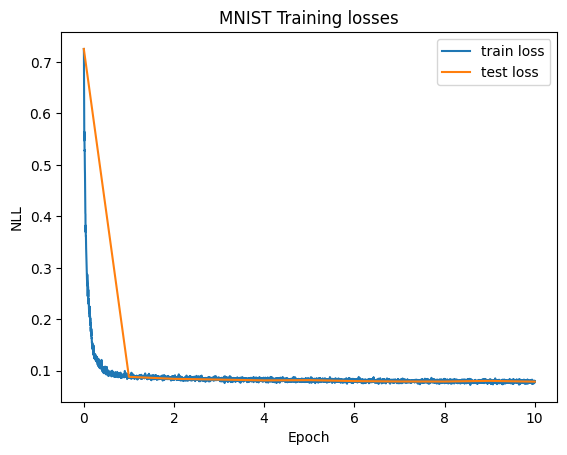

In [11]:
plt.figure()
n_epochs = len(test_losses) - 1
x_train = np.linspace(0, n_epochs, len(train_losses))
x_test = np.arange(n_epochs + 1)

plt.plot(x_train, train_losses, label='train loss')
plt.plot(x_test, test_losses, label='test loss')
plt.legend()
plt.title("MNIST Training losses")
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.show()

## Generating some samples

In [12]:
torch.cuda.empty_cache()

H, W = 28, 28
samples = torch.zeros(size=(100, 1, H, W)).to(device)

pixelcnn.eval()
with torch.no_grad():
    for i in range(H):
        for j in range(W):
            out = pixelcnn(normalize(samples))
            torch.bernoulli(out[:, :, i, j], out=samples[:, :, i, j])

samples = np.transpose(samples.detach().cpu().numpy(), [0, 2, 3, 1])

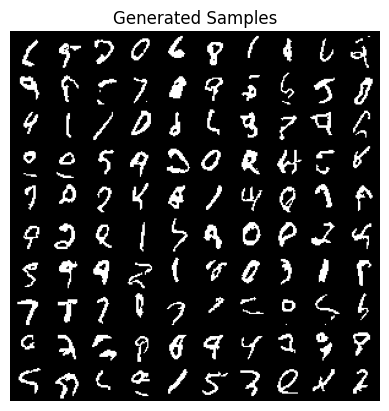

In [13]:
samples = (torch.FloatTensor(samples)).permute(0, 3, 1, 2)
grid_img = make_grid(samples, nrow=10)
plt.figure()
plt.title("Generated Samples")
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()